In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
import pandas as pd
from capstone_library import *
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, Matern, ExpSineSquared, RationalQuadratic, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

# Hints
## Drug Discovery Problem
In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

# Let's go!

Let's load the data.

In [2]:
X = np.load('initial_data/function_3/initial_inputs.npy')
y = np.load('initial_data/function_3/initial_outputs.npy')

In [3]:
# loading new data
new_queries = get_function_data_from_file('new_data/queries.txt', 3)
new_observ = get_function_data_from_file('new_data/observations.txt', 3)

In [4]:
# adding new_queries to X
new_queries = np.array(new_queries).reshape(-1, 3)
X = np.concatenate((X, new_queries), axis=0)

# adding new_observ to y
new_observ = np.array(new_observ).reshape(-1)
y = np.concatenate((y, new_observ), axis=0)

## Visualizing the data and thinking of the problem

In [5]:
# visualising the data as a table
df = pd.DataFrame(np.hstack((X, y.reshape(-1, 1))), columns=['x1', 'x2', 'x3', 'y'])
df.head(100)

,x1,x2,x3,y
0,0.171525,0.343917,0.248737,-0.112122
1,0.242114,0.644074,0.272433,-0.087963
2,0.534906,0.398501,0.173389,-0.111415
3,0.492581,0.611593,0.340176,-0.034835
4,0.134622,0.219917,0.458206,-0.048008
5,0.345523,0.941360,0.269363,-0.110621
6,0.151837,0.439991,0.990882,-0.398926
7,0.645503,0.397143,0.919771,-0.113869
8,0.746912,0.284196,0.226300,-0.131461
9,0.170477,0.697032,0.149169,-0.094190


In [6]:
# sort the data by the output, with the best value at the top
df = df.sort_values(by=['y'], ascending=False)
df.head(100)

,x1,x2,x3,y
3,0.492581,0.611593,0.340176,-0.034835
13,0.600097,0.725136,0.066089,-0.036378
27,0.500000,0.640000,0.340303,-0.040175
10,0.220549,0.297825,0.343555,-0.046947
4,0.134622,0.219917,0.458206,-0.048008
14,0.965995,0.861120,0.566829,-0.056758
22,0.690000,0.990000,0.880000,-0.074138
1,0.242114,0.644074,0.272433,-0.087963
9,0.170477,0.697032,0.149169,-0.094190
18,0.360000,0.000000,0.860000,-0.094265


Let's start with Bayesian Optimization with an Upper Confidence Bound acquisition function that uses a Gaussian Process as a surrogate model.

In [7]:
def get_next_query(gpr, kappa):

    # to optimize the acquisition function, we will simply use gridsearch over a space of 1,000,000 gridpoints
    x1 = np.linspace(0, 1, 100, endpoint=False)
    x2 = np.linspace(0, 1, 100, endpoint=False)
    x3 = np.linspace(0, 1, 100, endpoint=False)

    X_grid = []
    for i in range(len(x1)):
        for j in range(len(x2)):
            for k in range(len(x3)):
                X_grid.append([x1[i], x2[j], x3[k]])

    X_grid = np.array(X_grid)
    mean, std = gpr.predict(X_grid, return_std = True)
    ucb = mean + kappa * std

    idx_max = np.argmax(ucb)
    next_query = X_grid[idx_max]
    return next_query, X_grid, ucb


In [8]:
# parameters for the gaussian process
gpr = GaussianProcessRegressor()
gpr.fit(X, y)
print("Log Margin Likelihood =", gpr.log_marginal_likelihood_value_)
 
next_query, X_grid, ucb = get_next_query(gpr, 1)
print(format_query(next_query))

Log Margin Likelihood = -3032021.4636931457
0.990000-0.780000-0.990000


### Observations with original data
With a low kappa, the algorithm explores the space. With a high kappa, the algorithm exploits the space.
Next query: 0.990000-0.000000-0.670000

### Observations after query 1
Next query, still with kappa=1: 0.480000-0.990000-0.000000

Let's see how the acquisition function changes if we add points at the suggested next_query, assuming that they do not strike gold.

It looks like all the points are very close to the edge.

### After observation 20 ###
There are a few issues with the approach used so far:
1. We haven't really checked how good a fit the Gaussian process is for the data.
2. We haven't taken advantage of the information on one of the inputs being irrelevant.
3. We didn't make use of the repeated queries which, although unintentional, produced some information on the noise.

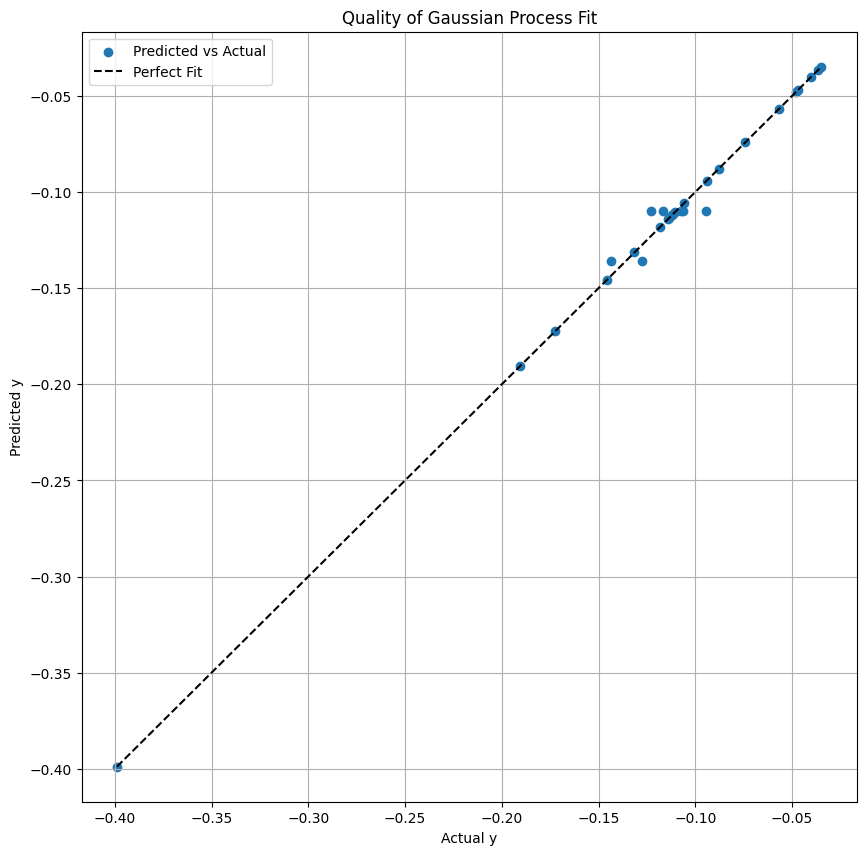

In [9]:
# Create the plot for visualizing the quality of the fit by comparing the predicted values with the true values
y_pred = gpr.predict(X)
fig = plt.figure(figsize=(10, 10))
plt.scatter(y, y_pred, label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', label='Perfect Fit')
plt.xlabel('Actual y')
plt.ylabel('Predicted y')
plt.title('Quality of Gaussian Process Fit')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# let's calculate the correlation between the inputs and the output
correlation = np.corrcoef(X.T, y)
correlation

array([[ 1.        ,  0.11245132, -0.24735282,  0.02932301],
       [ 0.11245132,  1.        , -0.44315255,  0.21922768],
       [-0.24735282, -0.44315255,  1.        , -0.28350225],
       [ 0.02932301,  0.21922768, -0.28350225,  1.        ]])

It looks like the first input $x_1$ has no direct linear correlation given that the correlation is only 0.028. To simplify the problem, let's remove it.

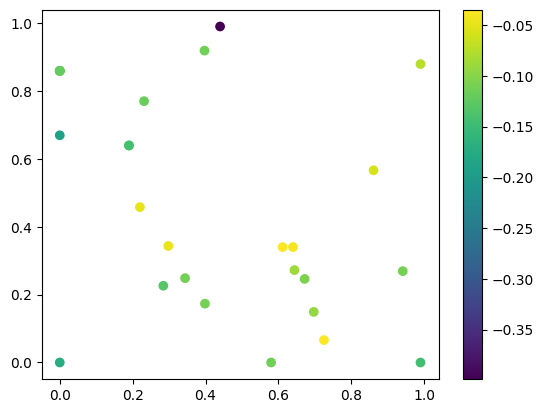

In [11]:
X = df[['x2', 'x3']].values
y = df['y'].values

# as we have moved onto a 2D input space, we can easily visualise the data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.colorbar()
plt.show()

In [12]:
# Initialize the Gaussian Process model and fit it
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X, y)

print("Log Margin Likelihood =", gpr.log_marginal_likelihood_value_)

Log Margin Likelihood = -3031586.356461278


/Users/paolo/anaconda3/envs/ML_course/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


No convergence yet. Let's try to increase the number of iterations and scale the data.

In [13]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Initialize the Gaussian Process model and fit it
kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
gpr.fit(X_scaled, y_scaled)

print("Log Margin Likelihood =", gpr.log_marginal_likelihood_value_)

Log Margin Likelihood = -673670282.4140188


The model didn't really improve and, in fact, the Log Marginal Likelihood decreased.
Let's work on the noise.

In [14]:
# Estimate the noise level based on repeated queries
df_scaled = pd.DataFrame(X_scaled, columns=['x2_scaled', 'x3_scaled'])
df_scaled['y_scaled'] = y_scaled
grouped = df_scaled.groupby(['x2_scaled', 'x3_scaled'])
noise_estimate = grouped['y_scaled'].var().dropna()
mean_noise_level = noise_estimate.mean()
print("Mean Noise Level =", mean_noise_level)

# Add a noise term and re-fit the model
kernel_with_noise = kernel + WhiteKernel(noise_level=mean_noise_level)
gpr_with_noise = GaussianProcessRegressor(kernel=kernel_with_noise, n_restarts_optimizer=20)
gpr_with_noise.fit(X_scaled, y_scaled)

print("Log Margin Likelihood =", gpr_with_noise.log_marginal_likelihood_value_)


Mean Noise Level = 0.027313446789826605
Log Margin Likelihood = -32.75855324999997


Great improvement compared to the original model, as the Log Likelihood is much closer to zero.
Let's plot the fit in 2D.

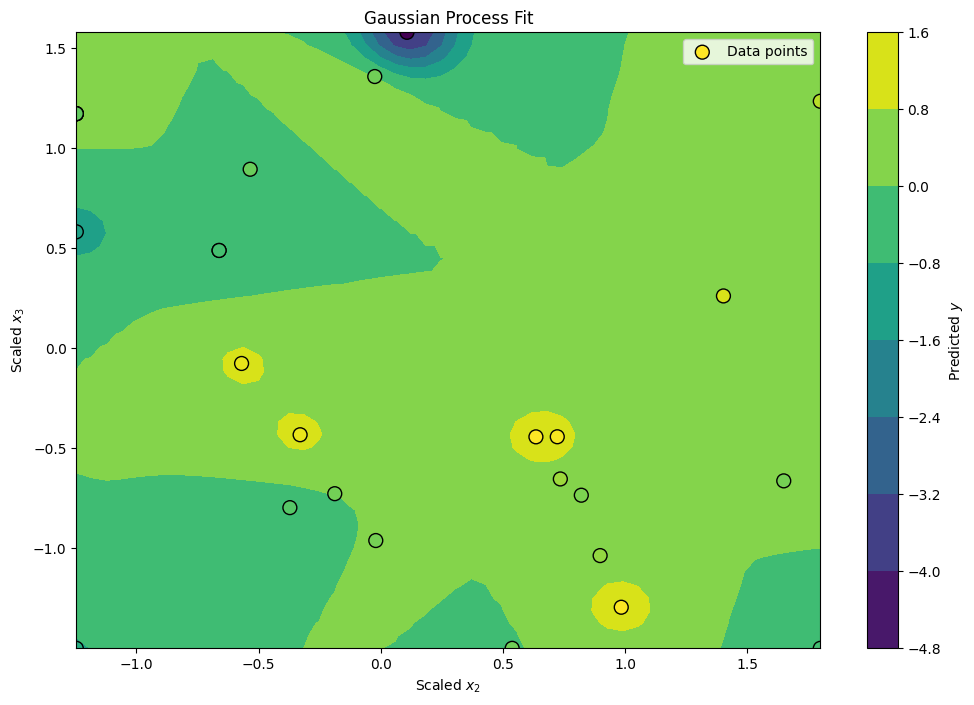

In [15]:
# Generate a grid for plotting the Gaussian Process fit
x2_values_plot = np.linspace(X_scaled[:, 0].min(), X_scaled[:, 0].max(), 50)
x3_values_plot = np.linspace(X_scaled[:, 1].min(), X_scaled[:, 1].max(), 50)

x2_grid_plot, x3_grid_plot = np.meshgrid(x2_values_plot, x3_values_plot)
candidate_points_plot = np.array([x2_grid_plot.ravel(), x3_grid_plot.ravel()]).T

# Use the Gaussian Process model to predict y values for the grid points
mean_pred_plot = gpr_with_noise.predict(candidate_points_plot)

# Reshape the predicted y values for plotting
mean_pred_plot_reshaped = mean_pred_plot.reshape(x2_grid_plot.shape)

# Create the plot
plt.figure(figsize=(12, 8))
contour = plt.contourf(x2_grid_plot, x3_grid_plot, mean_pred_plot_reshaped, cmap='viridis')
plt.colorbar(label='Predicted $y$')
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_scaled, edgecolors='k', s=100, cmap='viridis', label='Data points')
plt.title('Gaussian Process Fit')
plt.xlabel('Scaled $x_2$')
plt.ylabel('Scaled $x_3$')
plt.legend()
plt.show()


In [16]:
def get_next_query_2d(gpr, kappa, X):

    # to optimize the acquisition function, we will simply use gridsearch over a space of 10,000 gridpoints
    x2_values = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    x3_values = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    x2_grid, x3_grid = np.meshgrid(x2_values, x3_values)
    candidate_points = np.array([x2_grid.ravel(), x3_grid.ravel()]).T

    mean_pred, std_pred = gpr.predict(candidate_points, return_std=True)

    ucb = mean_pred + kappa * std_pred
    next_query_point_index = np.argmax(ucb)
    next_query_point = candidate_points[next_query_point_index]
    
    return next_query_point, candidate_points, ucb, mean_pred, std_pred

In [17]:
# exploitative kappa=1
next_query_point_scaled, X_grid, ucb, mean, std = get_next_query_2d(gpr_with_noise, 1, X_scaled)
next_query_point = scaler_X.inverse_transform([next_query_point_scaled])[0]
print(f"Next query point scaled [x2, x3]: {next_query_point_scaled}")
print(f"Next query point [x2, x3]: {next_query_point}")
print(f"Formatted next query point [x1=0.5, x2, x3]: 0.500000-{format_query(next_query_point)}")



Next query point scaled [x2, x3]: [-0.44644934 -0.25549715]
Next query point [x2, x3]: [0.26       0.40035631]
Formatted next query point [x1=0.5, x2, x3]: 0.500000-0.260000-0.400356


### After observation 23 (13th query)
Let's go with the suggested query: 0.500000-0.260000-0.400356